In [39]:
import enum
import seaborn as sns
from data_handling.Data_Processor import DataProcessor
import constants
import os
from statistics_methods.Statistics import StatisticsWrapper
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


In [52]:
raw_data_path = constants.PATH_TO_CORTEX_all_params_raw
chosen_rois_dict = constants.ROI_CORTEX
params_to_work_with = constants.ALL_PARAMS_WITH_SLOPES

In [53]:
subjects_raw_data = DataProcessor(raw_data_path, chosen_rois_dict, chosen_rois_dict).get_data_proccessed()
analyzed_data = StatisticsWrapper.calc_mean_per_subject_per_parameter_per_ROI(subjects_raw_data, params_to_work_with)
chosen_data = StatisticsWrapper.chose_relevant_data(analyzed_data, chosen_rois_dict, params_to_work_with, params_to_work_with)

In [54]:
group_a_name, group_b_name, col_divider, threshold = constants.YOUNG, constants.OLD, 'Age', constants.AGE_THRESHOLD
young_subjects, old_subjects = StatisticsWrapper.seperate_data_to_two_groups(chosen_data, col_divider, threshold)

In [12]:
StatisticsWrapper.plot_data_per_param_per_roi_next_to_each_other(young_subjects, old_subjects,
                                                                    params_to_work_with,
                                                                    group_a_name, group_b_name)

In [19]:
def extract_outliers(data, param):
     outliers = {}
     threshold = 1

     for roi_value, roi_name in chosen_rois_dict.items():
          roi_to_check_data = data[data.ROI == roi_value]
          Q1 = roi_to_check_data[param].quantile(0.25)
          Q3 = roi_to_check_data[param].quantile(0.75)
          IQR = Q3 - Q1


          outliers_df = roi_to_check_data[(roi_to_check_data[param] < Q1 - threshold * IQR) | (roi_to_check_data[param] > Q3 + threshold * IQR)]

          if outliers_df.subjects.values.size > 0:
               outliers[roi_value] = outliers_df.subjects.tolist()

     return outliers

In [ ]:
for param in params_to_work_with:
    subjects_outliers_counter = {}
    outliers_counter = {}
    outliers = extract_outliers(chosen_data, param)

    for roi, roi_outliers in outliers.items():
            for outlier in roi_outliers:
                if outlier in subjects_outliers_counter:
                    subjects_outliers_counter[outlier] += 1
                    outliers[outlier] += 1
                else:
                    subjects_outliers_counter[outlier]  = 1
                    outliers[outlier] += 1

    subjects_outliers_counter = dict(sorted(subjects_outliers_counter.items(), key=lambda item: item[1], reverse=True))
    print(f'{param} outliers: {outliers}')
    print(f'{param} outliers counter: {subjects_outliers_counter}')
    print('----------------------------------------------------------')

In [45]:
data_path = os.path.join(constants.ANALYSIS_DIR, 'H036_EV')
seg_path = os.path.join(data_path, os.listdir(data_path)[0], constants.BASIC_SEG)
brain_path = os.path.join(data_path, os.listdir(data_path)[0], constants.MAP_R1)

In [46]:
os.system(f'freeview -v {brain_path} {seg_path}:colormap=lut &')

0

In [64]:
def calculate_cv_for_subjects(data, params, x_axis):
    for param in params:
        # if 'Slope' in param:
        #     continue
        
        # Calculate CV for each subject
        subject_means = data.groupby('subjects')[[param, x_axis]].mean()
        subject_stds = data.groupby('subjects')[param].std()

        cv_data = pd.DataFrame({
            'subjects': subject_means.index,
            'CV': (subject_stds / subject_means[param]),
            x_axis: subject_means[x_axis]
        })

        model = LinearRegression()
        model.fit(np.array(cv_data[x_axis]).reshape(-1, 1), np.array(cv_data['CV']).reshape(-1, 1))
        # Get the slope and intercept
        slope = model.coef_[0]
        intercept = model.intercept_
        x_fit = np.linspace(min(cv_data[x_axis]), max(cv_data[x_axis]), 20)  # 100 points for smoother line


        # Create the plot
        plt.figure(figsize=(8, 6))  # Adjust figure size as needed
        plt.scatter(cv_data[x_axis], cv_data['CV'], color='blue', s=50, alpha=0.7)
        plt.plot(x_fit, slope * x_fit + intercept, color='red')
        plt.xlabel(x_axis)
        plt.ylabel('CV')
        plt.title(f'{param}')
        plt.grid(True)

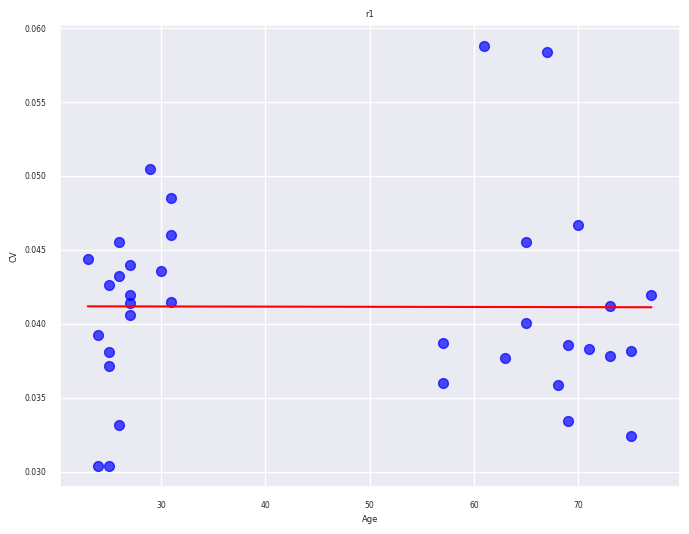

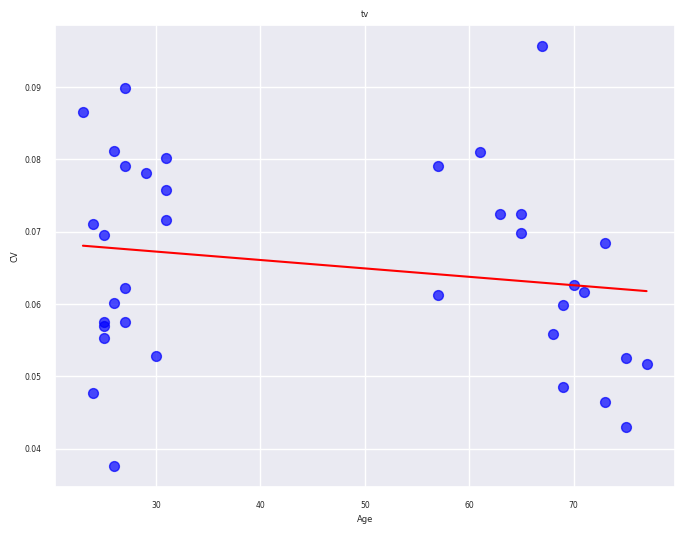

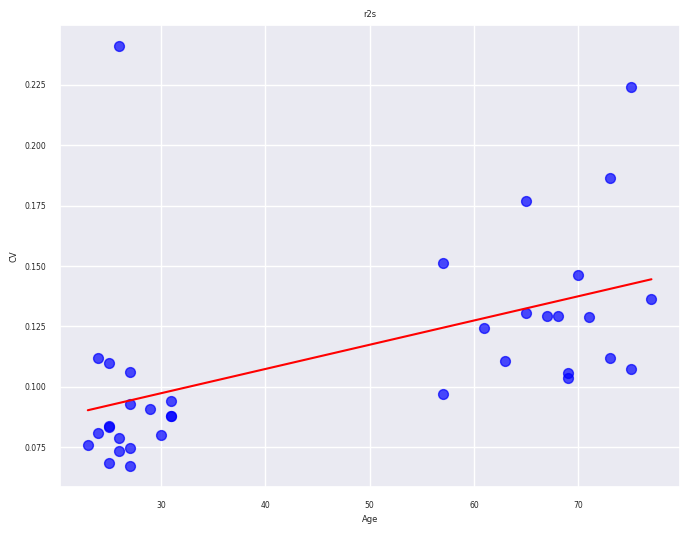

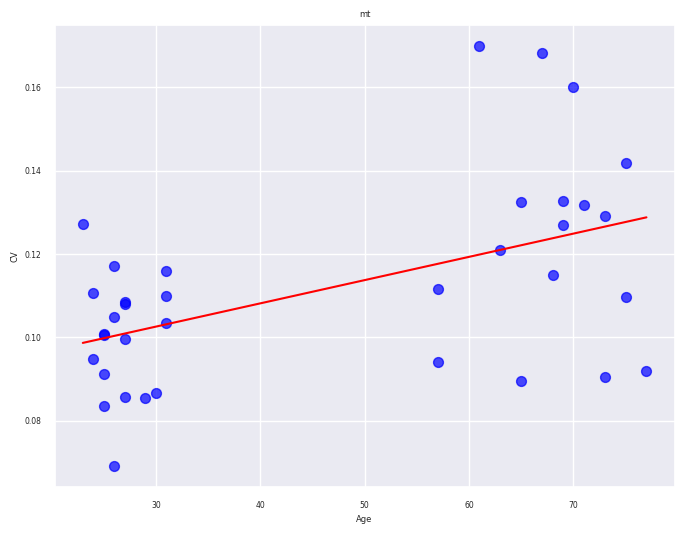

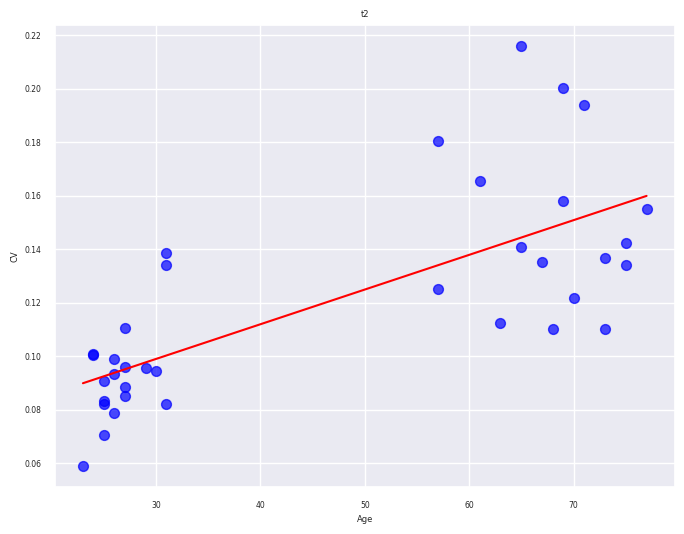

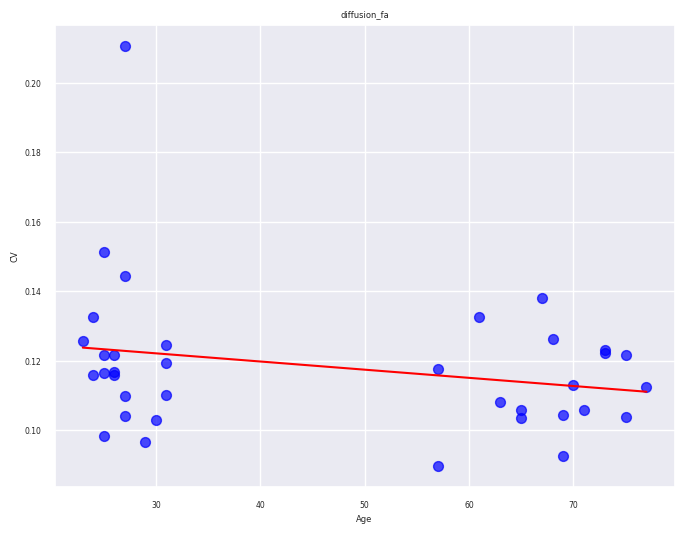

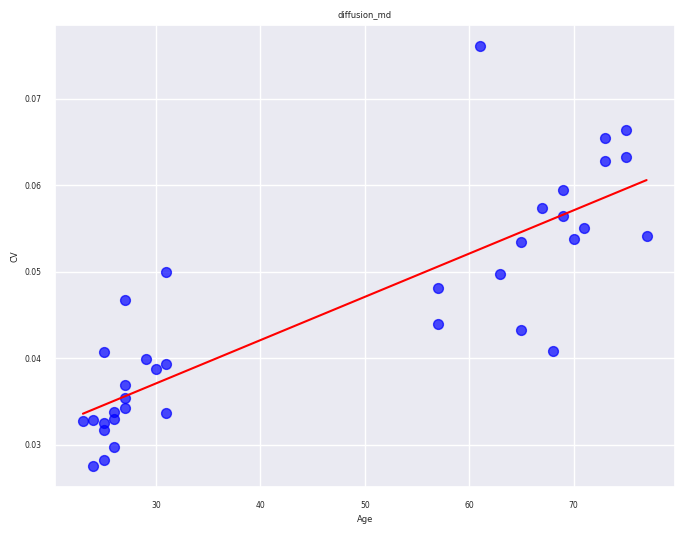

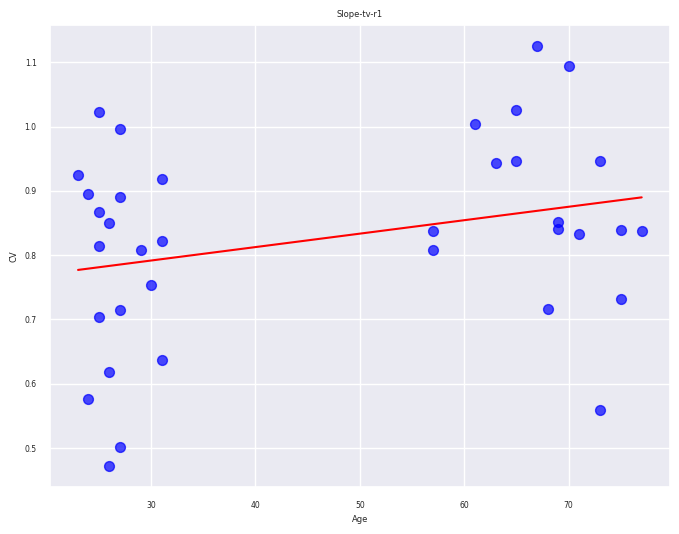

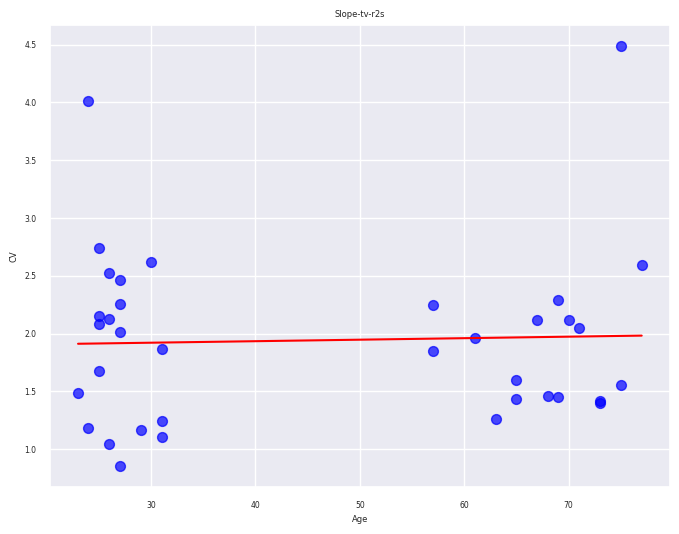

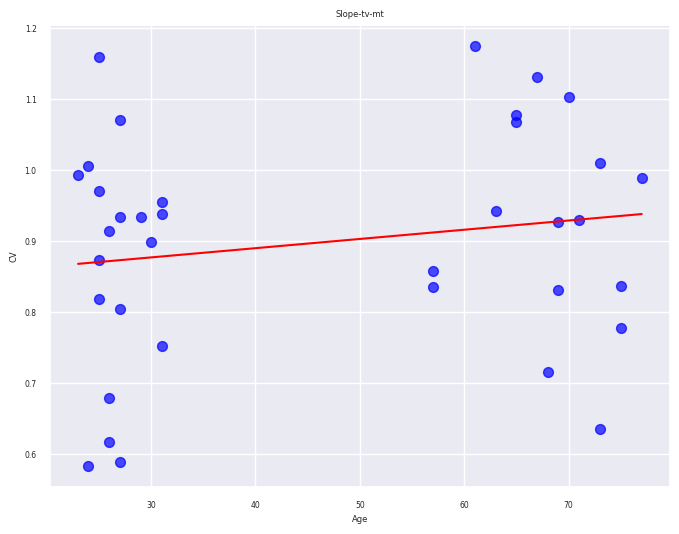

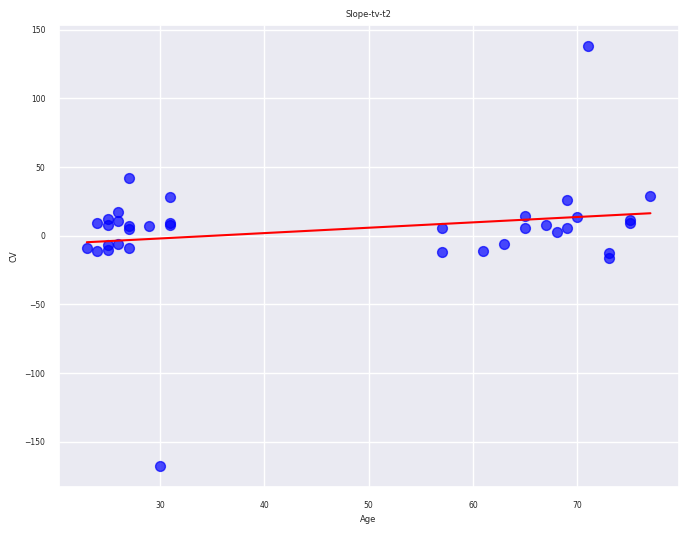

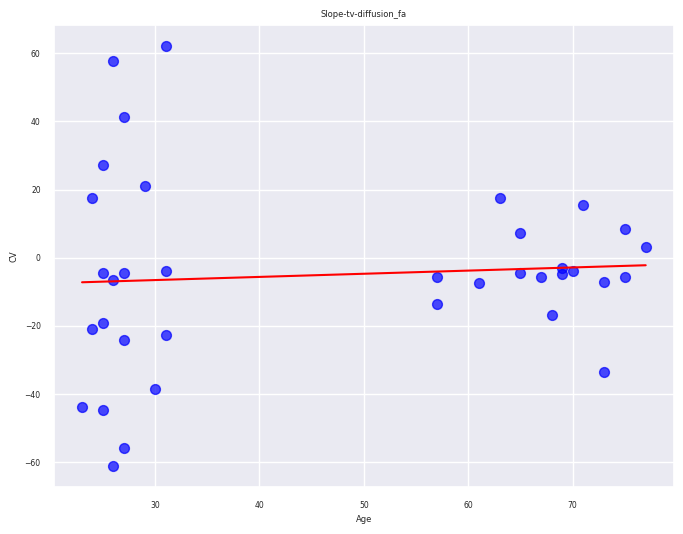

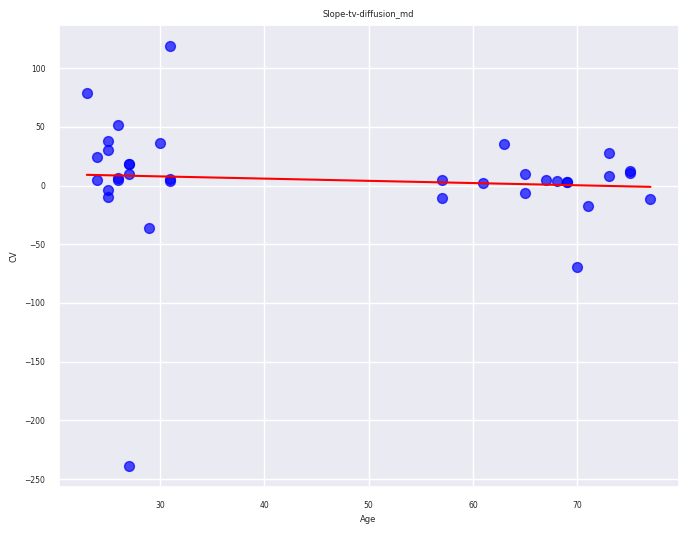

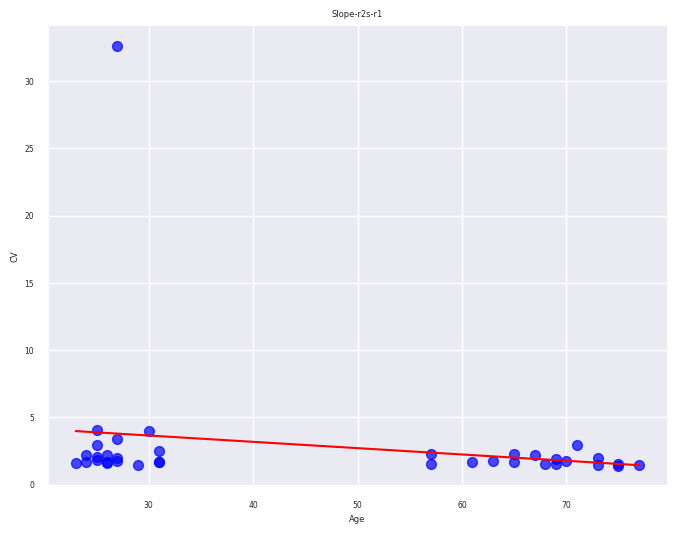

In [65]:
calculate_cv_for_subjects(chosen_data, params_to_work_with, 'Age')

In [ ]:
# Get the test subject
test_subject = subjects_raw_data.subjects.unique()[0]
x_axis = []
y_axis = []

# Filter the data for the test subject
test_subject_df = subjects_raw_data[subjects_raw_data['subjects'] == test_subject]
    
# Iterate over ROIs and print the lengths of the arrays
for roi in test_subject_df.ROI.unique():
    values = test_subject_df[test_subject_df.ROI == roi].iloc[0]['r1']
    x_axis.append(f'{roi}')
    y_axis.append(len(values))

plt.figure(figsize=(30, 20))  # Adjust figure size as needed
plt.scatter(x_axis, y_axis, color='red', s=50, alpha=0.7)
plt.xlabel('ROI')
plt.ylabel('num voxels')
# plt.title(f'{param}')
plt.grid(True)

In [ ]:
clusters_rois = StatisticsWrapper.hierarchical_clustering(chosen_data, params_to_work_with, 'complete',
                                                            title="all")['dendrogram_data']['ivl']
young_result = StatisticsWrapper.roi_correlations(young_subjects, params_to_work_with, clusters_rois,
                                                    'young')
old_result = StatisticsWrapper.roi_correlations(old_subjects, params_to_work_with, clusters_rois, 'old')

all_results = StatisticsWrapper.roi_correlations(chosen_data, params_to_work_with, clusters_rois, 'all')

In [62]:
young_result['corr_mean'] = young_result.apply(np.mean, axis=1)
old_result['corr_mean'] = old_result.apply(np.mean, axis=1)


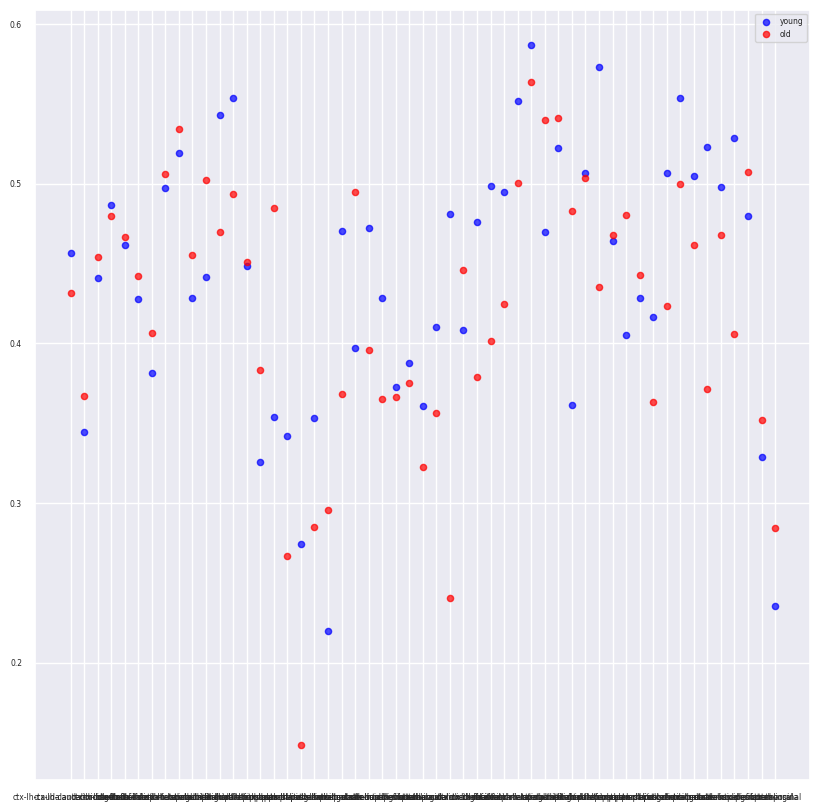

In [63]:
plt.figure(figsize=(10, 10))  # Adjust figure size as needed
plt.scatter(chosen_rois_dict.values(), young_result['corr_mean'].to_numpy(), color='blue', s=20, alpha=0.7, label='young')
plt.scatter(chosen_rois_dict.values(), old_result['corr_mean'].to_numpy(), color='red', s=20, alpha=0.7, label='old')
plt.legend()
plt.grid(True)